In [1]:
import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
from scregat.model import train_scregat, explain_model_ig
import pickle

In [2]:
import pickle
with open('./dataset_atac.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [3]:
dataset_graph = ATACGraphDataset('./input_graph/')

In [5]:
atac_file = './ATAC.h5ad'
RNA_h5ad_file = "./RNA.h5ad"


In [6]:
adata_rna = sc.read_h5ad(RNA_h5ad_file)
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('object')
df_rna = sum_counts(adata_rna,by = 'celltype', marker_gene_num=2000)


**finished identifying marker genes by COSG**


In [7]:
gene_anno = pd.read_csv('../gene_anno/gencode.v46.annotation.gtf', sep='\t', comment='#', header=None)


In [8]:
import re

# 提取gene_id和gene_name的函数
def extract_gene_info(attribute_string):
    gene_id = re.search(r'gene_id "([^"]+)"', attribute_string).group(1)
    gene_name = re.search(r'gene_name "([^"]+)"', attribute_string).group(1) if re.search(r'gene_name "([^"]+)"', attribute_string) else None
    return gene_id, gene_name

# 应用函数到attribute列
gene_anno['gene_id'], gene_anno['gene_name'] = zip(*gene_anno[8].apply(extract_gene_info))

# 展示结
gene_anno['gene_id'] = gene_anno['gene_id'].str.split('.').str[0]

# 展示结果
gene_anno[['gene_id', 'gene_name']].head()


,gene_id,gene_name
0,ENSG00000290825,DDX11L2
1,ENSG00000290825,DDX11L2
2,ENSG00000290825,DDX11L2
3,ENSG00000290825,DDX11L2
4,ENSG00000290825,DDX11L2


In [9]:
gene_anno_unique = gene_anno[['gene_id', 'gene_name']] 
gene_anno_unique = gene_anno_unique.drop_duplicates()

In [10]:
gene_num = sum(not item.startswith('chr') for item in dataset_atac.array_peak)
print(gene_num)

4457


In [11]:
gene_id_to_name = dict(zip(gene_anno_unique['gene_id'], gene_anno_unique['gene_name']))
df_rna = df_rna.rename(columns=gene_id_to_name)

In [12]:
gene_names_to_keep = list(dataset_atac.array_peak[:4457])
filtered_gene_anno = gene_anno_unique[gene_anno_unique['gene_name'].isin(gene_names_to_keep)]

filtered_gene_anno['order'] = filtered_gene_anno['gene_name'].apply(lambda x: gene_names_to_keep.index(x))
sorted_gene_anno = filtered_gene_anno.sort_values('order').drop('order', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:

filtered_gene_anno = sorted_gene_anno[sorted_gene_anno['gene_id'].isin(adata_rna.var_names)]

filtered_gene_anno = filtered_gene_anno.drop_duplicates(subset=['gene_name'])

In [14]:
select_gene = filtered_gene_anno.iloc[:, 0].values

In [15]:
df_rna = sum_counts(adata_rna,by = 'celltype',marker_gene_num=2000)

**finished identifying marker genes by COSG**


In [16]:
marker_index = list(select_gene)
raw_index = list(adata_rna.var_names)
index_array = []
for t in marker_index:
    index_array.append(raw_index.index(t))
index_array = np.array(index_array)

In [17]:
feature_matrix = adata_rna.X.toarray()

In [18]:
temp_features = feature_matrix[:, index_array]

In [19]:
scrna_seq = []
sc_dict = dict()
for i in range(len(adata_rna)):
    sc_dict[adata_rna.obs_names[i]] = temp_features[i]

In [20]:
#import os
import pandas as pd
import torch
import anndata as ad
from torch_geometric.loader import DataLoader
import scanpy as sc
from scregat.data_process import prepare_model_input,sum_counts,plot_edge, ATACGraphDataset
import numpy as np
import pickle
import random
from tqdm import tqdm

seq_vec = torch.load('./seq.pth')

data = dataset_atac.array_peak
torch_vector = torch.zeros(len(data))
for idx, item in enumerate(data):
    if item.startswith('chr'):
        torch_vector[idx] = 0 
    else:
        torch_vector[idx] = 1 
train_graph = []
test_graph = []
test_cell_type = []
train_cell_type = []
for i, sample in tqdm(enumerate(dataset_graph), total=len(dataset_graph), desc='Processing samples'):

    seq_data = seq_vec
    sample.seq_data = seq_data
    sample.id_vec = torch_vector
    temp_ts = torch.tensor(sc_dict[sample.cell])
    sample.sc_vec = temp_ts / temp_ts.sum()
    
    if random.randint(0, 3) == 0:
        test_graph.append(sample)
        test_cell_type.append(sample.y.item())
    else:
        train_graph.append(sample)
        train_cell_type.append(sample.y.item())



Processing samples: 100%|██████████| 23506/23506 [00:10<00:00, 2137.11it/s]


In [21]:
dataset_atac.array_celltype

array(['Astrocytes', 'IN-CGE', 'IN-MGE', 'IN-fetal', 'Microglia',
       'Oligodendrocytes'], dtype=object)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SCReGAT(torch.nn.Module):
    def __init__(self,
                 node_input_dim=2,
                 node_output_dim=8,
                 edge_embedding_dim=8,
                 hidden_channels=16,  # 增加 hidden_channels
                 gat_input_channels=8,
                 gat_hidden_channels=8,  # 增加 GAT 隐藏通道
                 seq_dim=768,
                 seq2node_dim=1,
                 max_tokens=1024,
                 dropout=0.4,  # 增加 dropout
                 num_head_1=16,  # 增加 GAT 头数
                 num_head_2=16):  # 增加 GAT 头数
        super(SCReGAT, self).__init__()

        # Sequence transformation layer (currently commented out in forward)
        self.NN_seq = nn.Sequential(
            nn.Linear(seq_dim, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, seq2node_dim),
        )

        # Node feature transformation with BatchNorm
        self.NN_node = nn.Sequential(
            nn.Linear(node_input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, node_output_dim),
        )

        # Edge feature transformation with BatchNorm
        self.NN_edge = nn.Sequential(
            nn.Linear(2, 12),
            nn.LayerNorm(12),
            nn.LeakyReLU(),
            nn.Linear(12, edge_embedding_dim)
        )

        # GAT layers with increased heads and self-loops
        self.NN_conv1 = GATConv(node_output_dim, hidden_channels, heads=num_head_1, dropout=dropout, edge_dim=edge_embedding_dim, add_self_loops=False)
        self.NN_flatten1 = nn.Linear(num_head_1 * hidden_channels, hidden_channels)

        self.NN_conv2 = GATConv(hidden_channels, hidden_channels, heads=num_head_2, dropout=dropout, add_self_loops=False)
        self.NN_flatten2 = nn.Linear(num_head_2 * hidden_channels, hidden_channels)

        self.dropout = nn.Dropout(0.2)  
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU()
        
        self.NN_cell_type = nn.Sequential(
            nn.Linear(4457, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 6),
            nn.Softmax()
        )
        

    def forward(self, seq_data, raw_x, edge_index, edge_tf, batch, gene_num):
        data = raw_x
        seq_data = self.NN_seq(seq_data)
        data = torch.cat((data, seq_data), dim=1)
        data = self.NN_node(data)
        
        hidden_edge_input = torch.cat((raw_x[edge_index[0]], raw_x[edge_index[1]]), dim=1)
        hidden_edge = self.NN_edge(hidden_edge_input).sigmoid()
        model.edge = torch.median(hidden_edge, dim=1)[0]
        data, atten_w1 = self.NN_conv1(data, edge_index, edge_attr=hidden_edge, return_attention_weights=True)
        data_1 = self.leaky(self.NN_flatten1(data))

        data_2, atten_w2 = self.NN_conv2(data_1, edge_tf, return_attention_weights=True)
        data_2 = self.leaky(self.NN_flatten2(data_2))
        
        data = data_1 + data_2
        self.data = data
        cell_type = self.NN_cell_type(torch.mean(data[:gene_num], dim=1))
        gene_out = -F.log_softmax(data[:gene_num], dim=1)[:, 0]
        return gene_out, atten_w1, cell_type

import torch
import torch.nn as nn

In [94]:
model = SCReGAT()

In [95]:
torch.cuda.empty_cache()

In [96]:
non_chr_peaks = [t for t in dataset_atac.array_peak if not t.startswith('chr')]
len(non_chr_peaks)

4457

In [97]:
import torch
import torch.nn as nn

class EdgeSparsityLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1):
        """
        自定义稀疏性损失函数
        :param alpha: 控制L1稀疏正则化的权重
        :param beta: 控制高权重边的激励
        :param gamma: 控制阈值惩罚的权重
        :param threshold: 边权重的阈值，小于该值的边将受到额外惩罚
        """
        super(EdgeSparsityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.threshold = threshold

    def forward(self, edge_weights):
        """
        计算自定义稀疏性损失
        :param edge_weights: 模型生成的边权重向量 (torch.Tensor)
        :return: 计算出的稀疏性损失 (torch.Tensor)
        """
        # L1 正则化：鼓励稀疏性
        sparsity_loss = self.alpha * torch.sum(torch.abs(edge_weights))

        # 高权重激励：放大较大的权重
        amplification_loss = -self.beta * torch.sum(torch.log(edge_weights + 1e-6))

        # 阈值惩罚：将小于阈值的边权重推向 0
        threshold_mask = edge_weights < self.threshold
        threshold_penalty = self.gamma * torch.sum(torch.pow(edge_weights[threshold_mask], 2))

        # 总损失：稀疏性、激励和阈值惩罚的组合
        loss = sparsity_loss + amplification_loss + threshold_penalty
        return loss


In [98]:
import torch
import random
from tqdm import tqdm

gene_num = len(sample.y_exp)
device = 'cuda:3'
model.to(device)
loss_exp = torch.nn.KLDivLoss(reduction='batchmean')
# loss_exp = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 20
drop_edge_rate = 0.1
attention_reg_weight = 0.01
sparse_loss_weight = 0.0001
batch_size = 1
criterion_sparse = EdgeSparsityLoss(alpha=1.0, beta=1.0, gamma=5.0, threshold=0.1)
criterion2 = torch.nn.CrossEntropyLoss()
max_grad_norm = 1.0

def drop_edges(edge_index, drop_rate=0.1):
    """随机丢弃边，依据设定的丢弃比例。
    Args:
        edge_index (torch.Tensor): 边的张量，形状为 (2, num_edges)。
        drop_rate (float): 要丢弃的边的比例。
    Returns:
        torch.Tensor: 丢弃部分边后的 edge_index。
    """
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges) > drop_rate
    return edge_index[:, mask]

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    running_loss1 = 0.0
    running_attention_loss = 0.0  # 记录 attention 正则化损失
    running_sparse_loss = 0.0  # 记录稀疏损失
    running_cell_loss = 0.0  # 记录 loss_cell

    random.shuffle(train_graph)
    train_loader = DataLoader(train_graph[:200], batch_size=batch_size, shuffle=True)
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}", unit="batch")
    for idx, sample in enumerate(progress_bar):
        gene_num = sample.y_exp.shape[0]
        optimizer.zero_grad()
        edge_index_dropped = sample.edge_index
        gene_pre, atten, cell_pre = model(
            sample.seq_data.to(device),
            sample.x.to(device),
            sample.edge_index.to(device),
            sample.edge_tf.T.to(device),
            sample.batch.to(device), gene_num
        )
        index = torch.where(sample.id_vec == 1)[0]
        loss1 = -loss_exp(gene_pre.flatten(), sample.y_exp.to(device))
        loss_cell = criterion2(cell_pre.unsqueeze(0), sample.y.to(device))
        attention_variance = torch.var(atten[1], dim=1).mean()
        attention_loss = attention_reg_weight * (3.0 - attention_variance)  # 鼓励方差
        edge_temp = model.edge.flatten()
        loss2 = sparse_loss_weight * criterion_sparse(edge_temp)
        loss = loss1 + attention_loss + loss_cell + loss2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # 更新运行中的损失
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_attention_loss += attention_loss.item()  # 记录注意力正则化损失
        running_sparse_loss += loss2.item()  # 记录稀疏损失
        running_cell_loss += loss_cell.item()  # 记录 loss_cell

        # 更新进度条，显示平均损失
        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            loss1=running_loss1 / (progress_bar.n + 1),
            attention_loss=running_attention_loss / (progress_bar.n + 1),
            sparse_loss=running_sparse_loss / (progress_bar.n + 1),
            cell_loss=running_cell_loss / (progress_bar.n + 1)
        )

        # 清空 CUDA 缓存，管理显存
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epoch}], Average Loss: {running_loss / len(train_loader):.4f}, "
          f"Loss1: {running_loss1 / len(train_loader):.4f}, Attention Loss: {running_attention_loss / len(train_loader):.4f}, "
          f"Sparse Loss: {running_sparse_loss / len(train_loader):.4f}, Cell Loss: {running_cell_loss / len(train_loader):.4f}")


Epoch 1/20: 100%|██████████| 200/200 [00:38<00:00,  5.21batch/s, attention_loss=0.03, cell_loss=1.77, loss=27, loss1=0.00227, sparse_loss=25.2]  


Epoch [1/20], Average Loss: 27.0124, Loss1: 0.0023, Attention Loss: 0.0300, Sparse Loss: 25.2072, Cell Loss: 1.7730


Epoch 2/20: 100%|██████████| 200/200 [00:42<00:00,  4.66batch/s, attention_loss=0.03, cell_loss=1.76, loss=25.6, loss1=0.00239, sparse_loss=23.8]


Epoch [2/20], Average Loss: 25.5851, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 23.7948, Cell Loss: 1.7579


Epoch 3/20: 100%|██████████| 200/200 [00:38<00:00,  5.21batch/s, attention_loss=0.03, cell_loss=1.76, loss=25.5, loss1=0.00194, sparse_loss=23.7]


Epoch [3/20], Average Loss: 25.5278, Loss1: 0.0019, Attention Loss: 0.0300, Sparse Loss: 23.7377, Cell Loss: 1.7582


Epoch 4/20: 100%|██████████| 200/200 [00:41<00:00,  4.82batch/s, attention_loss=0.03, cell_loss=1.74, loss=25.5, loss1=0.00239, sparse_loss=23.7]


Epoch [4/20], Average Loss: 25.4970, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 23.7281, Cell Loss: 1.7365


Epoch 5/20: 100%|██████████| 200/200 [00:41<00:00,  4.77batch/s, attention_loss=0.03, cell_loss=1.75, loss=25.5, loss1=0.00227, sparse_loss=23.7]


Epoch [5/20], Average Loss: 25.5096, Loss1: 0.0023, Attention Loss: 0.0300, Sparse Loss: 23.7243, Cell Loss: 1.7531


Epoch 6/20: 100%|██████████| 200/200 [00:39<00:00,  5.11batch/s, attention_loss=0.03, cell_loss=1.76, loss=25.5, loss1=0.00238, sparse_loss=23.7]


Epoch [6/20], Average Loss: 25.5125, Loss1: 0.0024, Attention Loss: 0.0300, Sparse Loss: 23.7224, Cell Loss: 1.7578


Epoch 7/20: 100%|██████████| 200/200 [00:41<00:00,  4.82batch/s, attention_loss=0.03, cell_loss=1.74, loss=25.5, loss1=0.00228, sparse_loss=23.7]


Epoch [7/20], Average Loss: 25.4978, Loss1: 0.0023, Attention Loss: 0.0300, Sparse Loss: 23.7212, Cell Loss: 1.7443


Epoch 8/20: 100%|██████████| 200/200 [00:40<00:00,  4.98batch/s, attention_loss=0.03, cell_loss=1.44, loss=25.2, loss1=0.00188, sparse_loss=23.7]


Epoch [8/20], Average Loss: 25.1945, Loss1: 0.0019, Attention Loss: 0.0300, Sparse Loss: 23.7205, Cell Loss: 1.4422


Epoch 9/20: 100%|██████████| 200/200 [00:41<00:00,  4.80batch/s, attention_loss=0.03, cell_loss=1.22, loss=25, loss1=0.0018, sparse_loss=23.7]   


Epoch [9/20], Average Loss: 24.9713, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7200, Cell Loss: 1.2195


Epoch 10/20: 100%|██████████| 200/200 [00:45<00:00,  4.42batch/s, attention_loss=0.03, cell_loss=1.12, loss=24.9, loss1=0.00177, sparse_loss=23.7]


Epoch [10/20], Average Loss: 24.8730, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7197, Cell Loss: 1.1216


Epoch 11/20: 100%|██████████| 200/200 [00:50<00:00,  3.99batch/s, attention_loss=0.03, cell_loss=1.16, loss=24.9, loss1=0.00177, sparse_loss=23.7]


Epoch [11/20], Average Loss: 24.9131, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7195, Cell Loss: 1.1619


Epoch 12/20: 100%|██████████| 200/200 [00:49<00:00,  4.06batch/s, attention_loss=0.03, cell_loss=1.13, loss=24.9, loss1=0.00178, sparse_loss=23.7]


Epoch [12/20], Average Loss: 24.8830, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7193, Cell Loss: 1.1319


Epoch 13/20: 100%|██████████| 200/200 [00:48<00:00,  4.11batch/s, attention_loss=0.03, cell_loss=1.12, loss=24.9, loss1=0.00178, sparse_loss=23.7]


Epoch [13/20], Average Loss: 24.8685, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7192, Cell Loss: 1.1176


Epoch 14/20: 100%|██████████| 200/200 [00:46<00:00,  4.29batch/s, attention_loss=0.03, cell_loss=1.1, loss=24.9, loss1=0.00177, sparse_loss=23.7] 


Epoch [14/20], Average Loss: 24.8520, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7191, Cell Loss: 1.1012


Epoch 15/20: 100%|██████████| 200/200 [00:49<00:00,  4.03batch/s, attention_loss=0.03, cell_loss=1.11, loss=24.9, loss1=0.00177, sparse_loss=23.7]


Epoch [15/20], Average Loss: 24.8561, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7190, Cell Loss: 1.1053


Epoch 16/20: 100%|██████████| 200/200 [00:47<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.1, loss=24.8, loss1=0.00179, sparse_loss=23.7] 


Epoch [16/20], Average Loss: 24.8472, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7190, Cell Loss: 1.0965


Epoch 17/20: 100%|██████████| 200/200 [00:47<00:00,  4.19batch/s, attention_loss=0.03, cell_loss=1.09, loss=24.8, loss1=0.00177, sparse_loss=23.7]


Epoch [17/20], Average Loss: 24.8432, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7189, Cell Loss: 1.0926


Epoch 18/20: 100%|██████████| 200/200 [00:48<00:00,  4.14batch/s, attention_loss=0.03, cell_loss=1.09, loss=24.8, loss1=0.00178, sparse_loss=23.7]


Epoch [18/20], Average Loss: 24.8401, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7189, Cell Loss: 1.0895


Epoch 19/20: 100%|██████████| 200/200 [00:45<00:00,  4.41batch/s, attention_loss=0.03, cell_loss=1.11, loss=24.9, loss1=0.00177, sparse_loss=23.7]


Epoch [19/20], Average Loss: 24.8653, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7188, Cell Loss: 1.1147


Epoch 20/20: 100%|██████████| 200/200 [00:47<00:00,  4.17batch/s, attention_loss=0.03, cell_loss=1.13, loss=24.9, loss1=0.00177, sparse_loss=23.7]

Epoch [20/20], Average Loss: 24.8846, Loss1: 0.0018, Attention Loss: 0.0300, Sparse Loss: 23.7188, Cell Loss: 1.1340


In [99]:
test_loader = DataLoader(test_graph, batch_size=1, shuffle=True, pin_memory=True)
model.train()
test_loss = 0.0 

device = 'cuda:0'
model.to(device)

cell_type = []
test_barcodes = []
with torch.no_grad():
    cell_link_atten = []
    cell_link_activity = []
    cell_link_edge = []
    cell_link_enhancer = []
    for idx, sample in tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Batches"):
        gene_pre, atten, _ = model(sample.seq_data.to(device),
                                sample.x.to(device), 
                                sample.edge_index.to(device), 
                                sample.edge_tf.T.to(device), 
                                sample.batch.to(device), gene_num)
        test_barcodes.append(sample.cell)
        cell_type.append(sample.y.item())
        import torch

        # 对 model.edge.flatten() 进行 0-1 缩放
        edge_flattened = model.edge.flatten().to('cpu')
        min_val = torch.min(edge_flattened)
        max_val = torch.max(edge_flattened)
        normalized_edge = (edge_flattened - min_val) / (max_val - min_val + 1e-10)  # 防止除以 0

        # 将归一化后的张量添加到 cell_link_edge
        cell_link_edge.append(normalized_edge)


        flattened_sample_x = sample.to(device).x[atten[0][1].cpu()].flatten()
        flattened_sample_enhancer = sample.to(device).x[atten[0][0].cpu()].flatten()
        atten1_max = torch.mean(atten[1], dim=1).to('cpu')
        cell_link_activity.append(flattened_sample_x.to('cpu'))
        cell_link_atten.append(atten1_max)
        cell_link_enhancer.append(flattened_sample_enhancer.to('cpu'))
#         edges = model.edge.flatten().cpu().numpy()
        torch.cuda.empty_cache()

Processing Batches: 100%|██████████| 5855/5855 [28:22<00:00,  3.44it/s]


In [100]:
sample.to(device).x[atten[0][1].cpu()].flatten()

tensor([2.1705, 0.6220, 1.0025,  ..., 0.6220, 0.0000, 0.6220], device='cuda:0')

In [101]:
sample.to(device).x[atten[0][0].cpu()].flatten()

tensor([2.1705, 0.6220, 1.0025,  ..., 0.0000, 0.6220, 0.6220], device='cuda:0')

In [102]:
cell_link_atten = torch.stack(cell_link_atten)
cell_link_edge = torch.stack(cell_link_edge)
cell_link_activity = torch.stack(cell_link_activity)
cell_link_enhancer = torch.stack(cell_link_enhancer)

In [69]:
len(cell_link_activity)

5855

In [70]:
import torch
from tqdm import tqdm
edge_index = atten[0]
n_edge = edge_index.size(1)
edge_importance = cell_link_atten.clone()  
gene_degrees = torch.bincount(edge_index[1])  


In [71]:
edge_degree_groups = {}
for i in range(n_edge):
    gene_node = edge_index[1, i]
    degree = gene_degrees[gene_node]
    if degree.item() not in edge_degree_groups:
        edge_degree_groups[degree.item()] = []
    edge_degree_groups[degree.item()].append(i)

for degree, indices in tqdm(edge_degree_groups.items(), desc="Normalizing edges by gene degree"):
    values_tensor = edge_importance[:, indices] 
    min_val, max_val = values_tensor.min(dim=1, keepdim=True)[0], values_tensor.max(dim=1, keepdim=True)[0]
    normalized_values = (values_tensor - min_val) / (max_val - min_val + 1e-10) 
    edge_importance[:, indices] = normalized_values  



Normalizing edges by gene degree: 100%|██████████| 168/168 [00:06<00:00, 25.31it/s] 


In [72]:
edge_importance

tensor([[0.0199, 0.5410, 0.4553,  ..., 0.0144, 0.0461, 0.0227],
        [0.2602, 0.1765, 0.0958,  ..., 0.0137, 0.0683, 0.0381],
        [0.1783, 0.3809, 0.4190,  ..., 0.0332, 0.0240, 0.0464],
        ...,
        [0.0988, 0.1784, 0.1955,  ..., 0.0292, 0.0484, 0.0534],
        [0.3963, 0.3989, 0.2709,  ..., 0.0407, 0.0599, 0.0499],
        [0.1121, 0.1153, 0.1147,  ..., 0.0207, 0.0146, 0.0342]])

In [73]:
model.edge.shape

torch.Size([237187])

In [357]:
edge_importance.shape

torch.Size([28, 237187])

In [358]:
edge_importance = edge_importance.to('cpu')
edge_index = edge_index.to('cpu')

In [359]:
edge_importance.shape

torch.Size([28, 237187])

In [384]:
cell_link_edge.shape

torch.Size([404, 237187])

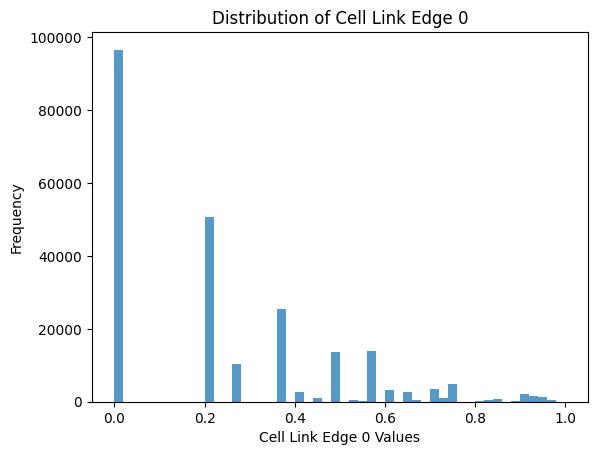

In [74]:
import matplotlib.pyplot as plt

# 假设 cell_link_edge 是一个 torch.Tensor 或 numpy 数组
cell_link_edge_0 = cell_link_edge[0].cpu().numpy()  # 如果是 torch.Tensor，先转换为 numpy

plt.hist(cell_link_edge_0, bins=50, alpha=0.75)
plt.xlabel('Cell Link Edge 0 Values')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Link Edge 0')
plt.show()


In [57]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

data_np = cell_link_edge.cpu().numpy() * cell_link_activity.cpu().numpy() * edge_importance.cpu().numpy()

# PCA on data1_mt (numpy array)
pca1 = PCA(n_components=2)
pca_result1 = pca1.fit_transform(data_np)


select_cell_id_np = cell_type

Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

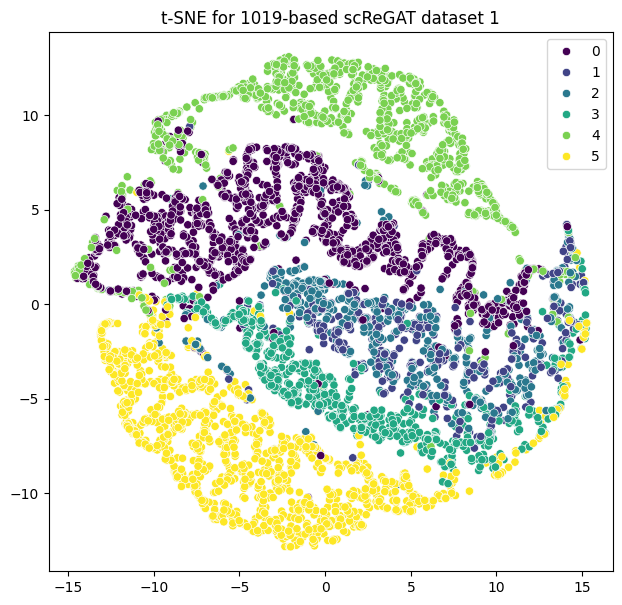

In [58]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)

# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


In [175]:
a

NameError: name 'a' is not defined

In [49]:
cell_type_id

NameError: name 'cell_type_id' is not defined

In [84]:
cell_link_activity[0, :] == cell_link_enhancer[0, :]

tensor([True, True, True,  ..., True, True, True])

In [79]:
cell_link_enhancer

tensor([[0.0000, 0.9638, 0.9638,  ..., 0.0000, 0.0000, 0.0000],
        [1.4013, 0.5343, 0.7780,  ..., 0.0000, 0.2114, 0.2114],
        [1.1798, 0.9173, 1.3876,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.8711, 0.6557, 1.0483,  ..., 0.0000, 0.0000, 0.0000],
        [1.9924, 0.9008, 1.3669,  ..., 0.0000, 0.0000, 0.0000],
        [1.4599, 0.7428, 1.1643,  ..., 0.0000, 0.0000, 0.0000]])

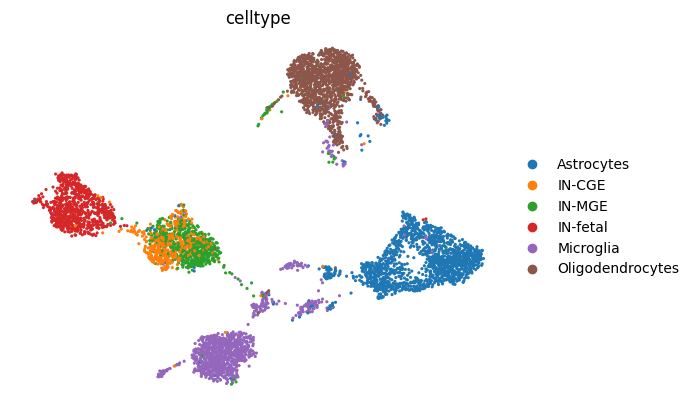

In [103]:
data_np = cell_link_activity.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [ ]:
umap_plot = sc.pl.umap(adata, color=['celltype'], wspace=0.4, frameon=False, show=False)
plt.savefig('./umap_plot.png')

print("UMAP plot saved as 'umap_plot.png'")

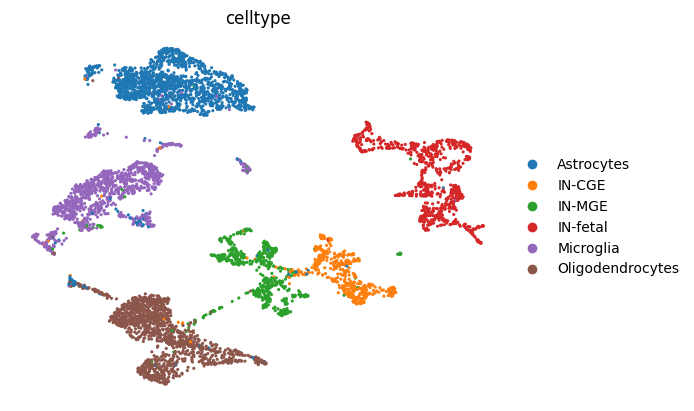

In [104]:
data_np = cell_link_enhancer.cpu().numpy()

import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

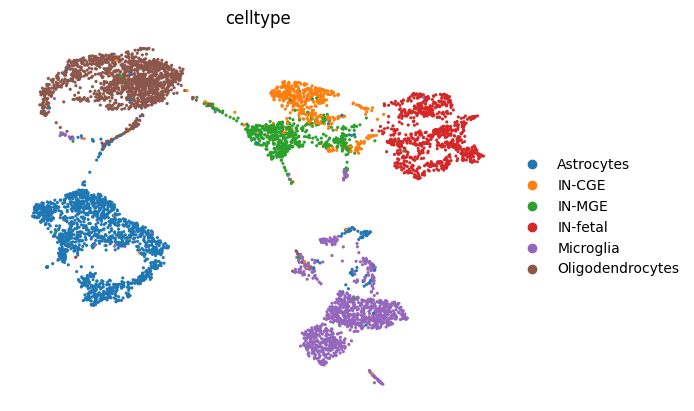

In [109]:
data_np = cell_link_edge.cpu().numpy() * cell_link_activity.cpu().numpy() 
import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

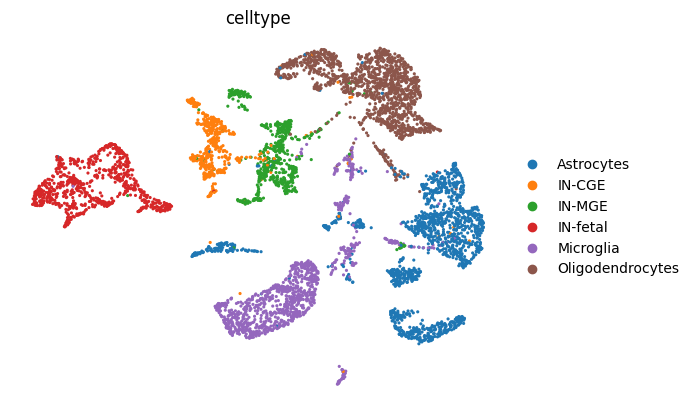

In [108]:
data_np = cell_link_activity.cpu().numpy()  * cell_link_atten.cpu().numpy()


import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

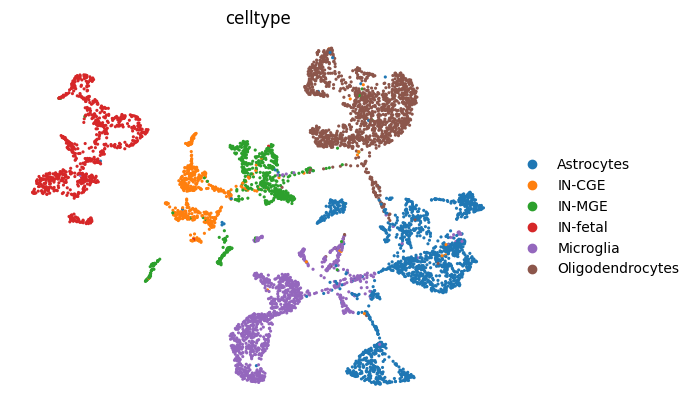

In [111]:
data_np = cell_link_atten.cpu().numpy()


import numpy as np
adata_edge = ad.AnnData(
    X=data_np, obs=dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)])
adata = adata_edge
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor='seurat')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=['celltype'], wspace=0.4,frameon=False)

In [117]:
validate_df = pd.read_csv('../Cortex_Mulqueen/PLAC_seq_promoter_interactome_map.csv')
import pandas as pd
promoters = validate_df
related_gene = promoters['Gene Name']
genes = [peak for peak in dataset_atac.array_peak if not peak.startswith('chr')]
common_genes = related_gene[related_gene.isin(genes)]
promoters_filtered = promoters[promoters['Gene Name'].isin(common_genes)]
print(promoters_filtered)


import pandas as pd

split_interactions = promoters_filtered[
    (promoters_filtered['PU1_active_promoter'] == True) &
    (promoters_filtered['Olig2_active_promoter'] == False) &
    (promoters_filtered['NeuN_active_promoter'] == False) &
    (promoters_filtered['LHX2_active_promoter'] == False)
]


split_interactions = split_interactions.dropna(subset=['PU1_enhancer_interactions'])

expanded_interactions = []
expanded_genes = []
for gene, interactions in zip(split_interactions['Gene Name'], split_interactions['PU1_enhancer_interactions']):
    interactions = interactions.split(',')
    for interaction in interactions:
        expanded_genes.append(gene)
        expanded_interactions.append(interaction)
filtered_df = pd.DataFrame({'Gene Name': expanded_genes, 'Interaction': expanded_interactions})
filtered_df[['chrom', 'start', 'end']] = filtered_df['Interaction'].str.split('[:-]', expand=True)

gene_peaks = [peak for peak in dataset_atac.array_peak if not peak.startswith('chr')]  
enhancer_peaks = [peak for peak in dataset_atac.array_peak if  peak.startswith('chr')]  

import pandas as pd
import pybedtools

filtered_df['start'] = pd.to_numeric(filtered_df['start'], errors='coerce').astype('Int64')
filtered_df['end'] = pd.to_numeric(filtered_df['end'], errors='coerce').astype('Int64')

filtered_df = filtered_df[filtered_df['start'] < filtered_df['end']]

filtered_df = filtered_df.dropna(subset=['chrom', 'start', 'end'])

enhancer_peaks_formatted = [peak.replace('-', '\t').split('\t') for peak in enhancer_peaks]
df2 = pd.DataFrame(enhancer_peaks_formatted, columns=['chrom', 'start', 'end'])
df1 = filtered_df
df1['start'] = pd.to_numeric(df1['start'], errors='coerce').astype('Int64')
df1['end'] = pd.to_numeric(df1['end'], errors='coerce').astype('Int64')
df1 = df1[df1['start'] < df1['end']]

df2['start'] = pd.to_numeric(df2['start'], errors='coerce').astype('Int64')
df2['end'] = pd.to_numeric(df2['end'], errors='coerce').astype('Int64')
df2 = df2[df2['start'] < df2['end']]

# 将两个 DataFrame 转换为 BedTool 对象
bed1 = pybedtools.BedTool.from_dataframe(df1[['chrom', 'start', 'end']])
bed2 = pybedtools.BedTool.from_dataframe(df2[['chrom', 'start', 'end']])

# 找到 df2 中与 df1 相交的 peaks
intersection = bed2.intersect(bed1)

# 将交集结果转换为 DataFrame
intersection_df = intersection.to_dataframe(names=['chrom', 'start', 'end'])

# 将交集的 chrom, start, end 用 "-" 拼接成新的列
intersection_df['peak'] = intersection_df['chrom'] + '-' + intersection_df['start'].astype(str) + '-' + intersection_df['end'].astype(str)

# 返回拼接后的 peaks
result_peaks = intersection_df['peak'].tolist()

# 打印结果
print(result_peaks)


       PeakID   Chr      Start        End  \
14         15  chr1    1238517    1245441   
18         19  chr1    1333584    1336012   
35         36  chr1    1820222    1824079   
39         40  chr1    1981115    1982541   
40         41  chr1    2004489    2007767   
...       ...   ...        ...        ...   
15856   15857  chrX  153361439  153363929   
15863   15864  chrX  153664794  153667477   
15871   15872  chrX  153976701  153980209   
15890   15891  chrY   15589120   15592544   
15892   15893  chrY   16634026   16639249   

                                  Annotation  \
14        intron (NM_030649, intron 1 of 23)   
18                  promoter-TSS (NR_135154)   
35      intron (NM_001282538, intron 1 of 9)   
39                  promoter-TSS (NR_135509)   
40     intron (NM_001242874, intron 1 of 14)   
...                                      ...   
15856   intron (NM_001316337, intron 1 of 4)   
15863     intron (NM_001493, intron 1 of 10)   
15871      intron (NR_10411

In [118]:
result_peaks = np.unique(result_peaks)
import pandas as pd
import pybedtools

# 假设 filtered_df 和 result_peaks 已定义

# 将 filtered_df 转换为 BED 格式的字符串列表
filtered_bed_data = filtered_df[['chrom', 'start', 'end', 'Gene Name']].values
filtered_bed_entries = ['\t'.join(map(str, row)) for row in filtered_bed_data]

# 创建 filtered_df 的 pybedtools BedTool 对象
filtered_bedtool = pybedtools.BedTool('\n'.join(filtered_bed_entries), from_string=True)

# 将 result_peaks 转换为 BED 格式的字符串列表
result_peaks_parsed = []
for peak in result_peaks:
    chrom, start, end = peak.split('-')
    result_peaks_parsed.append([chrom, int(start), int(end)])

result_peaks_bed_entries = ['\t'.join(map(str, row)) for row in result_peaks_parsed]

# 创建 result_peaks 的 pybedtools BedTool 对象
result_peaks_bedtool = pybedtools.BedTool('\n'.join(result_peaks_bed_entries), from_string=True)

# 使用 pybedtools 的 intersect 函数查找重叠的区间
intersected = filtered_bedtool.intersect(result_peaks_bedtool, wa=True, wb=True)

# 将结果转换为 DataFrame
intersected_df = pd.read_csv(intersected.fn, sep='\t', header=None)
intersected_df.columns = ['chrom', 'start', 'end', 'Gene Name', 'peak_chrom', 'peak_start', 'peak_end']

intersected_df['peak_region'] = intersected_df['peak_chrom'] + '-' + intersected_df['peak_start'].astype(str) + '-' + intersected_df['peak_end'].astype(str)

# 删除不再需要的单独列（如果不需要保留）
intersected_df = intersected_df.drop(columns=['peak_chrom', 'peak_start', 'peak_end'])
intersected_df = intersected_df.drop_duplicates(subset=['Gene Name', 'peak_region'])


In [119]:
intersected_df

,chrom,start,end,Gene Name,peak_region
0,chr1,12185000,12230000,TNFRSF1B,chr1-12185398-12186057
1,chr1,12185000,12230000,TNFRSF1B,chr1-12194663-12194938
2,chr1,12185000,12230000,TNFRSF1B,chr1-12196407-12197011
3,chr1,12185000,12230000,TNFRSF1B,chr1-12198258-12198762
4,chr1,12185000,12230000,TNFRSF1B,chr1-12208339-12209598
...,...,...,...,...,...
9862,chr9,132645000,132810000,FNBP1,chr9-132799887-132800473
9863,chr9,132645000,132810000,FNBP1,chr9-132809375-132810000
9864,chr9,132645000,132810000,FNBP1,chr9-132809375-132810073
9902,chr9,132805000,132825000,FNBP1,chr9-132814345-132815301


In [127]:
validate_links = []
for t in intersected_df.values:
    validate_links.append(t[3] + '-' + t[4])

In [128]:
link_list = atten[0].cpu().numpy()
link_str = []
for t in range(len(link_list[0])):
    enhancer = dataset_atac.array_peak[link_list[0][t]]
    promoter = dataset_atac.array_peak[link_list[1][t]]
    
    # link_str.append('(\''+ promoter + '\','  + '\'' + enhancer + '\')')
    link_str.append(promoter + '-' + enhancer)
edge_index = []
for t in validate_links:
    try:
        edge_index.append(link_str.index(t))
    except:
        continue

array(['6032_GCTAAGTTCTTGAGCG-1', '5936_GGAACCTGTCATTAGG-1',
       '11_GAAAGCCAGCAGGTGG-1', ..., '6007_AAGGTCAAGCTTAACA-1',
       '5936_GGCAGGATCATTACAG-1', '5977_TGTGCTGAGCAATAGG-1'], dtype='<U25')

In [135]:
data_np = cell_link_atten

In [137]:
cell_link_atten.shape

torch.Size([5855, 237187])

array(['Oligodendrocytes', 'Oligodendrocytes', 'IN-fetal', ...,
       'Astrocytes', 'Astrocytes', 'Oligodendrocytes'], dtype=object)

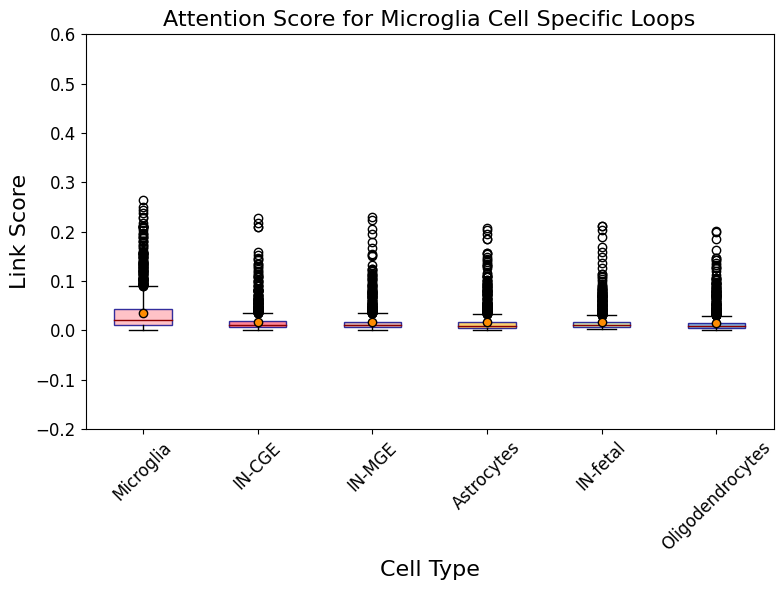

In [164]:
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming cell_link_mt and cell_type are defined
temp = cell_link_atten * cell_link_edge
cell_type = torch.tensor(cell_type, dtype=torch.int64)

# Select matching indices
temp = temp[:, edge_index]

# Move to CPU
temp_cpu = temp.cpu()
cell_type_cpu = dataset_atac.adata.obs.loc[np.concatenate(test_barcodes)]['celltype'].values

# Normalize temp to 0-1 range
scaler = MinMaxScaler()
temp_normalized = torch.tensor(scaler.fit_transform(temp_cpu), dtype=torch.float32)

# Calculate mean for each cell type
unique_types = np.unique(cell_type_cpu)
means = [torch.mean(temp_normalized[cell_type_cpu == t, :], dim=0) for t in unique_types]

# Sort cell types by mean in descending order
mean_values = [torch.mean(temp_normalized[cell_type_cpu == t]) for t in unique_types]
sorted_indices = np.argsort(mean_values)[::-1]
sorted_types = unique_types[sorted_indices]
sorted_means = [means[i] for i in sorted_indices]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
boxprops = dict(color="darkblue", facecolor="lightblue", alpha=0.8)
medianprops = dict(color="darkred")
meanpointprops = dict(marker="o", markeredgecolor="black", markerfacecolor="darkorange")
meanlineprops = dict(color="orange", linestyle="--", linewidth=1.5)

# Create boxplot
bp = ax.boxplot(sorted_means, patch_artist=True, boxprops=boxprops, medianprops=medianprops,
                meanprops=meanpointprops, showmeans=True)

# Custom colors
colors = ['#FFB3BA', '#FF677D', '#D4A5A5', '#F9C74F', '#C2D7A3', '#6C9FD0']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Set title and labels
ax.set_title('Attention Score for Microglia Cell Specific Loops', fontsize=16)
ax.set_xlabel('Cell Type', fontsize=16)
ax.set_ylabel('Link Score', fontsize=16)
ax.set_ylim(-0.2, 0.6)
ax.set_xticklabels([f'{t}' for t in sorted_types], fontsize=8)
ax.tick_params(axis='both', labelsize=12)

# Rotate x-ticks
plt.xticks(rotation=45)

# Set background color
fig.patch.set_facecolor('white')

# Save the figure
# fig.savefig('./fig/fig3_cell_typeNeur.png')

# Show plot
plt.tight_layout()
plt.show()


In [149]:
unique_types

array(['Astrocytes', 'IN-CGE', 'IN-MGE', 'IN-fetal', 'Microglia',
       'Oligodendrocytes'], dtype=object)

In [ ]:
cell_link_activity

In [ ]:
dataset_atac.adata.obs.loc[.index, :]

Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

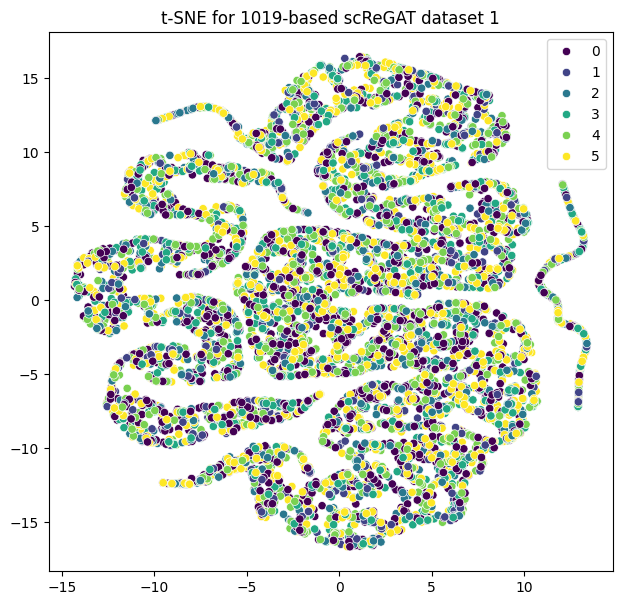

In [334]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)


# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


Text(0.5, 1.0, 't-SNE for 1019-based scReGAT dataset 1')

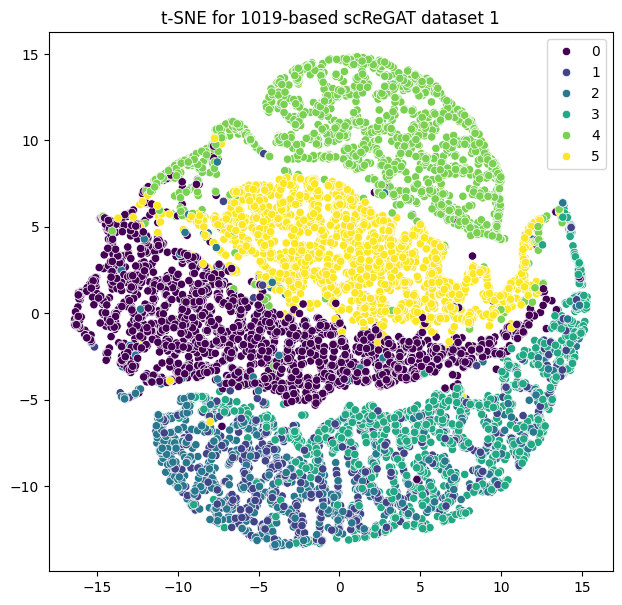

In [332]:
# Assuming select_cell_id is a torch tensor; convert it to numpy array if needed


# t-SNE on PCA results for data1_mt
tsne1 = TSNE(n_components=2, perplexity=25, n_iter=300)
tsne_result1 = tsne1.fit_transform(pca_result1)


# Plotting t-SNE results
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result1[:,0], y=tsne_result1[:,1], hue=select_cell_id_np, palette='viridis')
plt.title('t-SNE for 1019-based scReGAT dataset 1')


In [323]:
count_chr_start = sum(t.startswith('chr')==False for t in dataset_atac.array_peak)
print(count_chr_start)


4457


In [324]:
gene_anno

,0,1,2,3,4,5,6,7,8,gene_id,gene_name
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; gene_type ""lncRNA...",ENSG00000290825,DDX11L2
1,chr1,HAVANA,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000290825.1""; transcript_id ""EN...",ENSG00000290825,DDX11L2
...,...,...,...,...,...,...,...,...,...,...,...
3467151,chrM,ENSEMBL,transcript,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",ENSG00000210195,MT-TT
3467152,chrM,ENSEMBL,exon,15888,15953,.,+,.,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",ENSG00000210195,MT-TT
3467153,chrM,ENSEMBL,gene,15956,16023,.,-,.,"gene_id ""ENSG00000210196.2""; gene_type ""Mt_tRN...",ENSG00000210196,MT-TP
3467154,chrM,ENSEMBL,transcript,15956,16023,.,-,.,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",ENSG00000210196,MT-TP


In [330]:
pd.DataFrame(dataset_atac.array_peak[:4457]).to_csv('./gene_node.csv', index=False)